In [107]:
#Hack to fix missing PROJ4 env var
import os
import conda
import seaborn as sns
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# from geopy.distance import vincenty
from geopy.distance import great_circle
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
from haversine import haversine, Unit
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
df = pd.read_json('/home/madhu/Desktop/final_DB/live_dataset.json')

In [6]:
df.head()

,id,timestamp,latitude,longitude
0,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 19:52:26,12.880172,77.784798
1,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 20:52:26,12.993111,77.596512
2,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 21:52:26,12.975756,77.463615
3,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 22:52:26,12.974606,77.615150
4,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 23:52:26,12.997514,77.706261


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         241 non-null    object        
 1   timestamp  241 non-null    datetime64[ns]
 2   latitude   241 non-null    float64       
 3   longitude  241 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 7.7+ KB


In [8]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['second'] = df['timestamp'].dt.second

In [9]:
df.head()

,id,timestamp,latitude,longitude,year,month,day,hour,minute,second
0,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 19:52:26,12.880172,77.784798,2020,6,28,19,52,26
1,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 20:52:26,12.993111,77.596512,2020,6,28,20,52,26
2,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 21:52:26,12.975756,77.463615,2020,6,28,21,52,26
3,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 22:52:26,12.974606,77.615150,2020,6,28,22,52,26
4,0xF161df29a8451D5d5Ae98E9eBF5f0DB6999E65F1,2020-06-28 23:52:26,12.997514,77.706261,2020,6,28,23,52,26


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         241 non-null    object        
 1   timestamp  241 non-null    datetime64[ns]
 2   latitude   241 non-null    float64       
 3   longitude  241 non-null    float64       
 4   year       241 non-null    int64         
 5   month      241 non-null    int64         
 6   day        241 non-null    int64         
 7   hour       241 non-null    int64         
 8   minute     241 non-null    int64         
 9   second     241 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 19.0+ KB


## DBSCAN-euclidean

In [23]:
def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['latitude'])
    lon = list(stns['longitude'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['longitude']), list(df['latitude']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

KeyboardInterrupt: 

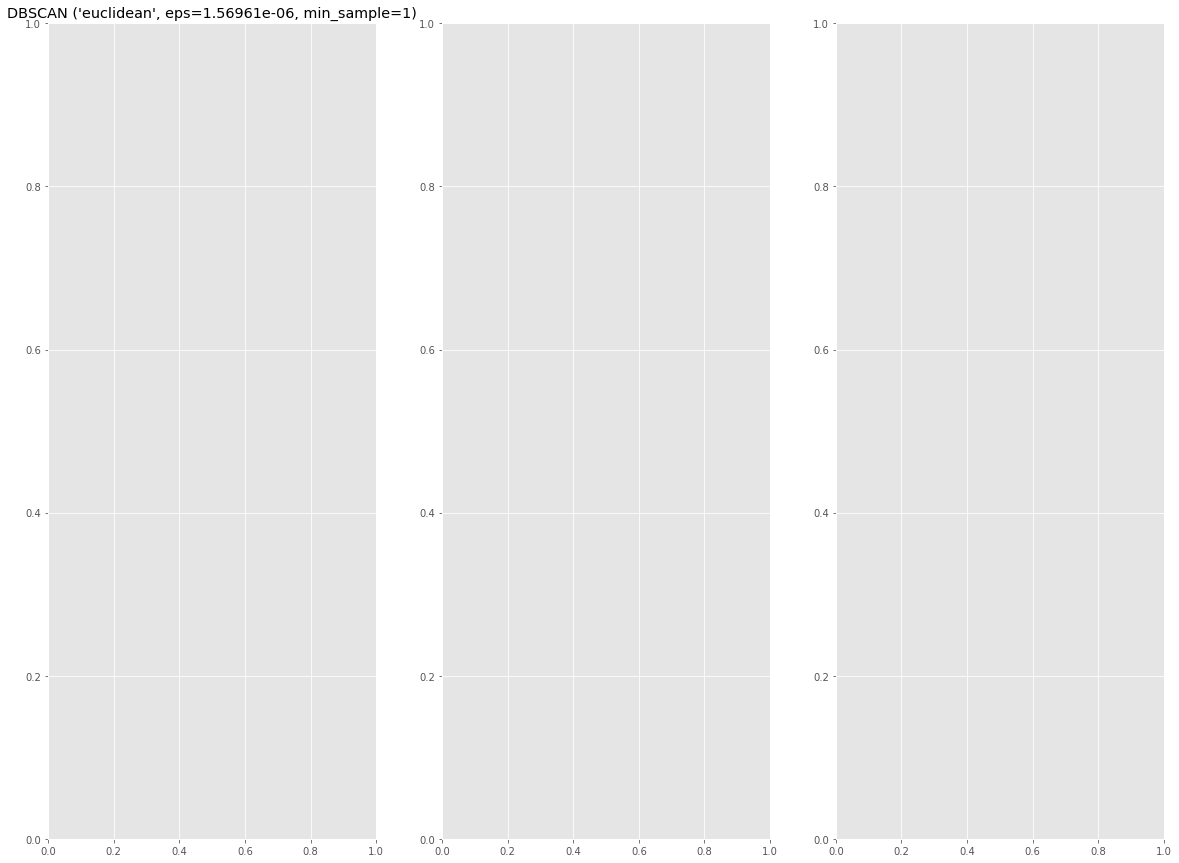

In [12]:
eps = [0.00000156961]   # unit: latitude/longitude
min_sample = [1, 2, 3]
# eps = [0.004, 0.005]
# min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        model = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(df[['latitude', 'longitude']])
        df['cluster'] = model.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN ('euclidean', eps={}, min_sample={})".format(eps[i], min_sample[j]))
        
        plot_stations_map(ax, df)

## Self-defined (haversine)

In [77]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return haversine((lat1, lon1), (lat2, lon2))

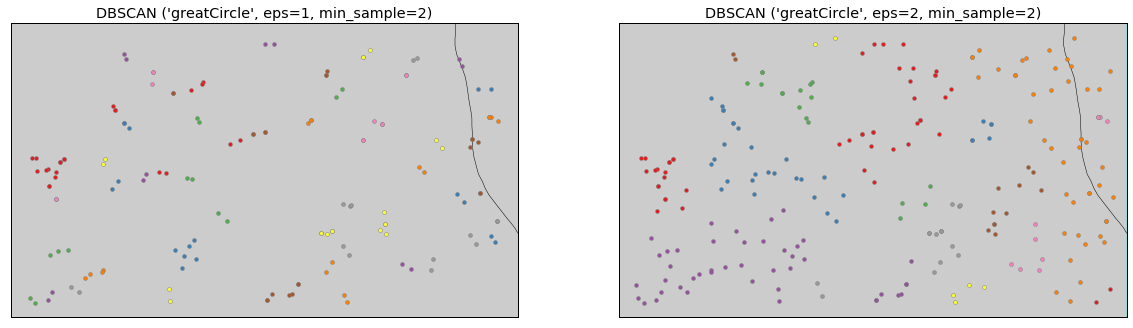

In [78]:
eps = [1, 2]    # unit: meter
min_sample = [2]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
    for i in range(n1):
        model = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(df[['latitude', 'longitude']])
        df['cluster'] = model.labels_.tolist()

        ax = plt.subplot(n2, n1, n1*j+i+1)
        ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

        plot_stations_map(ax, df)

In [ ]:
len(df['cluster'])

In [ ]:
df['cluster']

In [ ]:
df.head(50)

In [ ]:
haversine((12.917987,77.556328), (12.931447,77.521484))

In [ ]:
df['id'][0]

In [ ]:
def get_infected_ids(input_id):
    input_id_clusters = []
    for i in range(len(df)):
        if df['id'][i] == input_id:
            if df['cluster'][i] in input_id_clusters:
                pass
            else:
                input_id_clusters.append(df['cluster'][i])
    print(input_id_clusters)

    member_cluster = []
    for cluster in input_id_clusters:
        member_list = df.loc[df['cluster'] == cluster, 'id']
        for i in range(len(member_list)):
            member_node = member_list.iloc[i]
            if member_node in member_cluster:
                pass
            else:
                member_cluster.append(member_node)
    return member_cluster

input_id = '0xD4310FFd2C5c4FCd18b00F0Dd7b94d2ED0289Ca2'
get_infected_ids(input_id)

# Testing the model

In [95]:
basePath = os.path.dirname(os.path.abspath('testing_dataset.json'))
dftrain = pd.read_json(basePath + '/' + 'testing_dataset.json')

In [96]:
dftrain.describe()

,latitude,longitude
count,200.000000,200.000000
mean,13.053505,77.613998
std,0.090117,0.040333
min,12.977913,77.554453
25%,12.978760,77.589498
50%,12.996021,77.591577
75%,13.120859,77.646277
max,13.249076,77.706015


In [89]:
dftrain.head()

,id,timestamp,latitude,longitude
0,0xB,2020-07-04 15:35:30,12.978181,77.591362
1,0xC,2020-07-04 20:35:30,12.978630,77.591359
2,0xC,2020-07-04 22:35:30,12.979592,77.588637
3,0xA,2020-07-04 19:35:30,12.978879,77.591527
4,0xI,2020-07-04 17:35:30,12.978996,77.592302


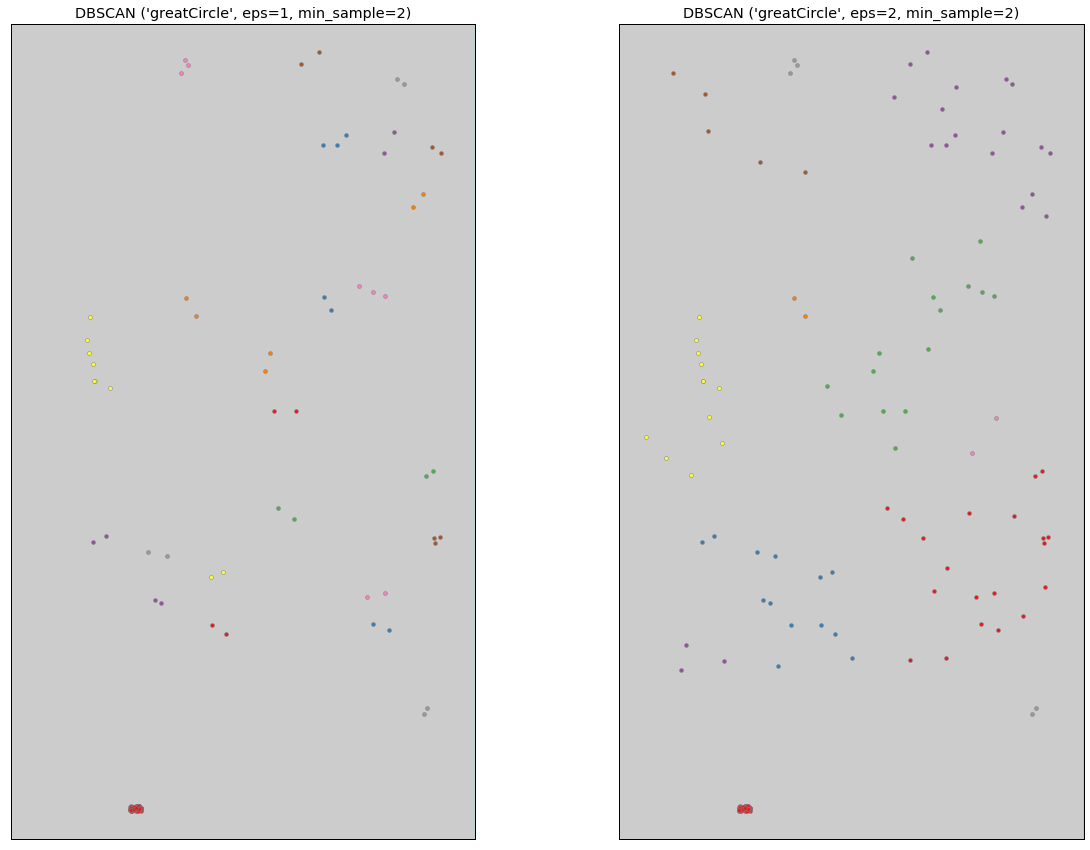

In [92]:
eps = [1, 2]    # unit: meter
min_sample = [2]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
    for i in range(n1):
        model = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(dftrain[['latitude', 'longitude']])
        dftrain['cluster'] = model.labels_.tolist()

        ax = plt.subplot(n2, n1, n1*j+i+1)
        ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

        plot_stations_map(ax, dftrain)

In [93]:
dftrain.head(50)

,id,timestamp,latitude,longitude,cluster
0,0xB,2020-07-04 15:35:30,12.978181,77.591362,0
1,0xC,2020-07-04 20:35:30,12.978630,77.591359,0
2,0xC,2020-07-04 22:35:30,12.979592,77.588637,0
3,0xA,2020-07-04 19:35:30,12.978879,77.591527,0
4,0xI,2020-07-04 17:35:30,12.978996,77.592302,0
5,0xF,2020-07-04 19:35:30,12.978210,77.591771,0
6,0xD,2020-07-04 16:35:30,12.979533,77.591651,0
7,0xE,2020-07-04 13:35:30,12.979439,77.588446,0
8,0xB,2020-07-04 12:35:30,12.978826,77.589205,0
9,0xG,2020-07-04 13:35:30,12.979384,77.589284,0


In [46]:
haversine((13.194585, 77.591991), (13.161761, 77.591378))

3.6504706630971073

In [86]:
def get_infected_ids(input_id):
    input_id_clusters = []
    for i in range(len(dftrain)):
        if dftrain['id'][i] == input_id:
            if dftrain['cluster'][i] in input_id_clusters:
                pass
            else:
                input_id_clusters.append(dftrain['cluster'][i])
    print(input_id_clusters)

    member_cluster = []
    for cluster in input_id_clusters:
        member_list = dftrain.loc[dftrain['cluster'] == cluster, 'id']
        for i in range(len(member_list)):
            member_node = member_list.iloc[i]
            if member_node in member_cluster:
                pass
            else:
                member_cluster.append(member_node)
    return member_cluster

input_id = '0xA'
get_infected_ids(input_id)

[0]


['0xB', '0xC', '0xA', '0xI', '0xF', '0xD', '0xE', '0xG', '0xJ', '0xH']

# Using model on live data

In [376]:
basePath = os.path.dirname(os.path.abspath('testing_dataset.json'))
dflive = pd.read_json(basePath + '/' + 'testing_dataset.json')

In [377]:
dflive.describe()

,latitude,longitude
count,7.000000,7.000000
mean,13.207552,77.686355
std,0.008742,0.021069
min,13.197712,77.659922
25%,13.198601,77.671143
50%,13.212990,77.682363
75%,13.214488,77.706601
max,13.215987,77.706712


In [378]:
dflive.head()

,id,timestamp,latitude,longitude
0,0xM,2020-07-04 23:35:30,13.212990,77.682363
1,0xN,2020-07-04 23:35:30,13.212990,77.682363
2,0xL,2020-07-04 17:35:30,13.215987,77.659922
3,0xZ,2020-07-04 17:35:30,13.215987,77.659922
4,0xX,2020-07-04 16:47:14,13.198600,77.706600


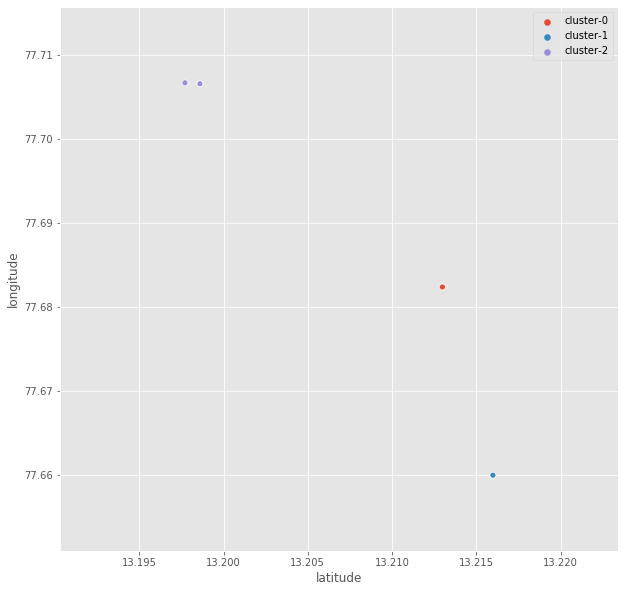

In [379]:
kms_per_radian = 6371.0088
epsilon = 0.0018288 # a radial distance of 6 feet, which is medically presribed
# eps = 1    # unit: meter
min_sample = 2
# n1, n2 = len(eps), len(min_sample)
# plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

# for j in range(n2):
#     for i in range(n1):
model = DBSCAN(eps=epsilon, min_samples=2, metric='haversine').fit(dflive[['latitude', 'longitude']])
dflive['cluster'] = model.labels_.tolist()
#         ax = plt.subplot(n2, n1, n1*j+i+1)
#         ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))

#         plot_stations_map(ax, dflive)
labels = model.labels_
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(dflive['latitude'], dflive['longitude'], hue=["cluster-{}".format(x) for x in labels])        

In [380]:
dflive.head(50)

,id,timestamp,latitude,longitude,cluster
0,0xM,2020-07-04 23:35:30,13.212990,77.682363,0
1,0xN,2020-07-04 23:35:30,13.212990,77.682363,0
2,0xL,2020-07-04 17:35:30,13.215987,77.659922,1
3,0xZ,2020-07-04 17:35:30,13.215987,77.659922,1
4,0xX,2020-07-04 16:47:14,13.198600,77.706600,2
5,0xY,2020-07-04 16:47:14,13.198601,77.706601,2
6,0xA,2020-07-04 16:47:14,13.197712,77.706712,2


In [381]:
def get_infected_ids(input_id):
    input_id_clusters = []
    for i in range(len(dflive)):
        if dflive['id'][i] == input_id:
            if dflive['cluster'][i] in input_id_clusters:
                pass
            else:
                input_id_clusters.append(dflive['cluster'][i])
    print(input_id_clusters)
#     print()
    if input_id in dflive.loc[dflive['cluster'] == -1, 'id'].unique():
        print(input_id, "is currently in noise cluster. Can not return suitbale infections")
        return []

    member_cluster = []
    for cluster in input_id_clusters:
        member_list = dflive.loc[dflive['cluster'] == cluster, 'id']
        for i in range(len(member_list)):
            member_node = member_list.iloc[i]
            if (member_node not in member_cluster) and (member_node != input_id):
                member_cluster.append(member_node)
            else:
                pass
    return member_cluster

In [382]:
input_id = '0xA'
get_infected_ids(input_id)

[2]


['0xX', '0xY']

In [375]:
haversine((13.1977123, 77.7067123), (13.1986000, 77.7066000), unit='m')

99.4537373312357